# Insurance Data EDA

## Import Dependencies

In [2]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add src to path so we can import our modules
sys.path.append(os.path.abspath(os.path.join('..')))

## Load Modules

In [4]:
from src.data_loader import DataLoader
from src.plotter import EDAPlotter

file_path = '../data/raw/MachineLearningRating_v3.txt'

## Load Data

In [7]:
# Load
loader = DataLoader(file_path)
df = loader.load_data()
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')
# Display basic stats
print(f"Dataset Shape: {df.shape}")
df.info()

INFO:src.data_loader:Data loaded successfully.


Dataset Shape: (1000098, 52)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   UnderwrittenCoverID       1000098 non-null  int64         
 1   PolicyID                  1000098 non-null  int64         
 2   TransactionMonth          1000098 non-null  datetime64[ns]
 3   IsVATRegistered           1000098 non-null  bool          
 4   Citizenship               1000098 non-null  object        
 5   LegalType                 1000098 non-null  object        
 6   Title                     1000098 non-null  object        
 7   Language                  1000098 non-null  object        
 8   Bank                      854137 non-null   object        
 9   AccountType               959866 non-null   object        
 10  MaritalStatus             991839 non-null   object        
 11  Gender               

## Guiding Question 1 - The loss Ratio

In [8]:
# Calculate Overall Loss Ratio
overall_loss_ratio = df['TotalClaims'].sum() / df['TotalPremium'].sum()
print(f"Overall Portfolio Loss Ratio: {overall_loss_ratio:.2%}")

# Group by Province
province_risk = df.groupby('Province').agg({
    'TotalPremium': 'mean',
    'TotalClaims': 'mean'
})
province_risk['LossRatio'] = province_risk['TotalClaims'] / province_risk['TotalPremium']
print(province_risk.sort_values('LossRatio', ascending=False))

Overall Portfolio Loss Ratio: 104.77%
               TotalPremium  TotalClaims  LossRatio
Province                                           
Gauteng           61.071115    74.630009   1.222018
KwaZulu-Natal     77.800695    84.234293   1.082693
Western Cape      57.416793    60.831482   1.059472
North West        52.276258    41.317426   0.790367
Mpumalanga        53.801205    38.785147   0.720897
Free State        64.373780    43.822975   0.680758
Limpopo           61.899038    40.927553   0.661199
Eastern Cape      70.546672    44.713432   0.633813
Northern Cape     49.617253    14.026726   0.282699


## Guiding Question 2 - Financial Distributions

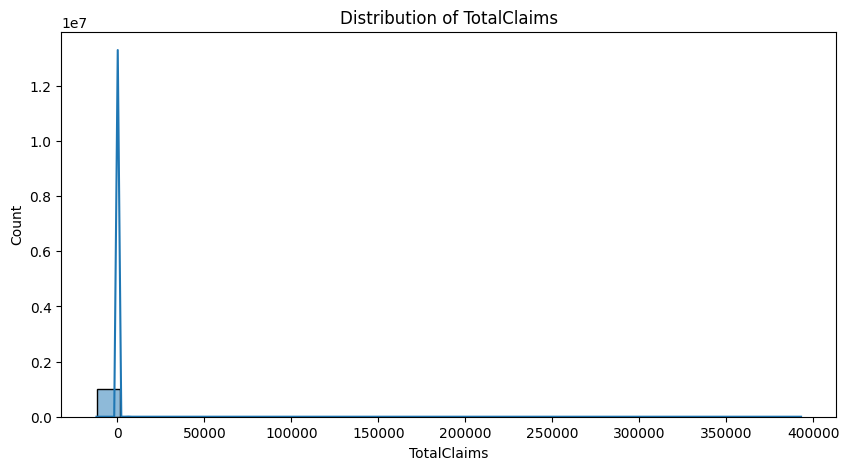

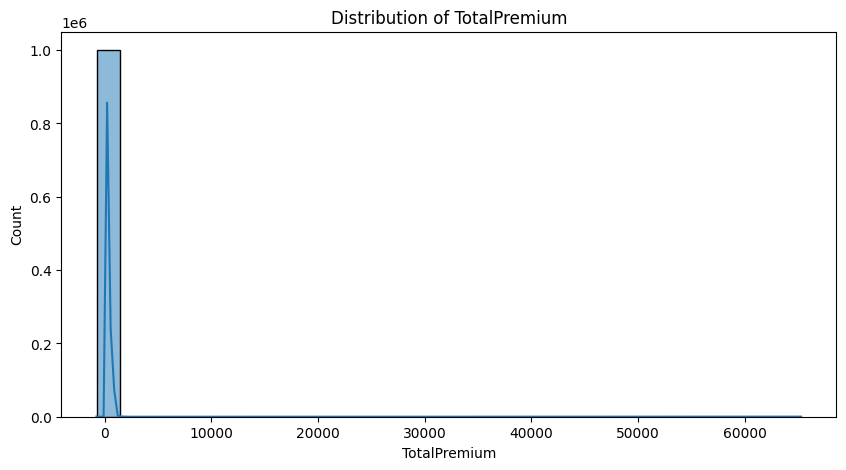

In [9]:
analyzer = EDAPlotter(df)
# Plot Claims Distribution
analyzer.plot_univariate_dist('TotalClaims')
# Plot Premium Distribution
analyzer.plot_univariate_dist('TotalPremium')

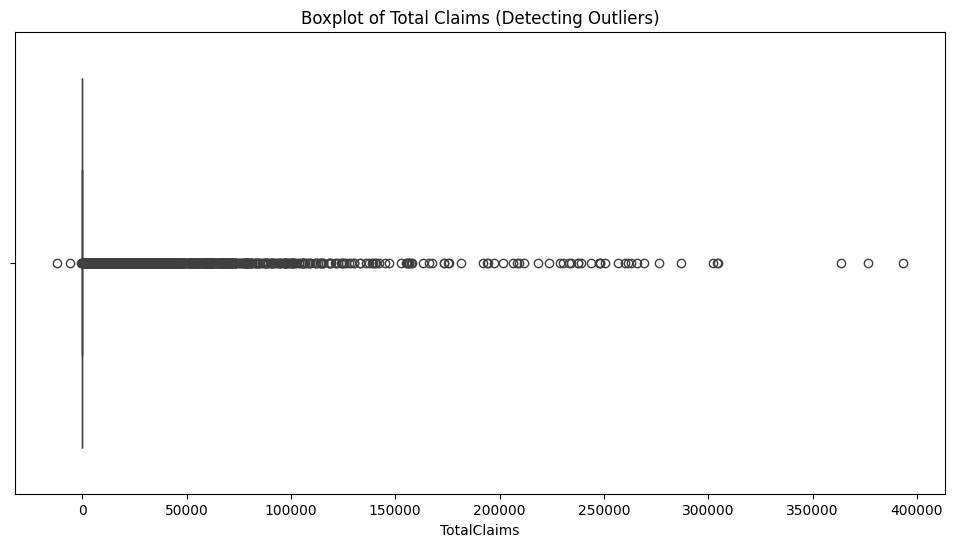

In [10]:
# Box plot for outliers
plt.figure(figsize=(12,6))
sns.boxplot(x=df['TotalClaims'])
plt.title('Boxplot of Total Claims (Detecting Outliers)')
plt.show()

## Guiding Question 3 - Temporal Trends

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


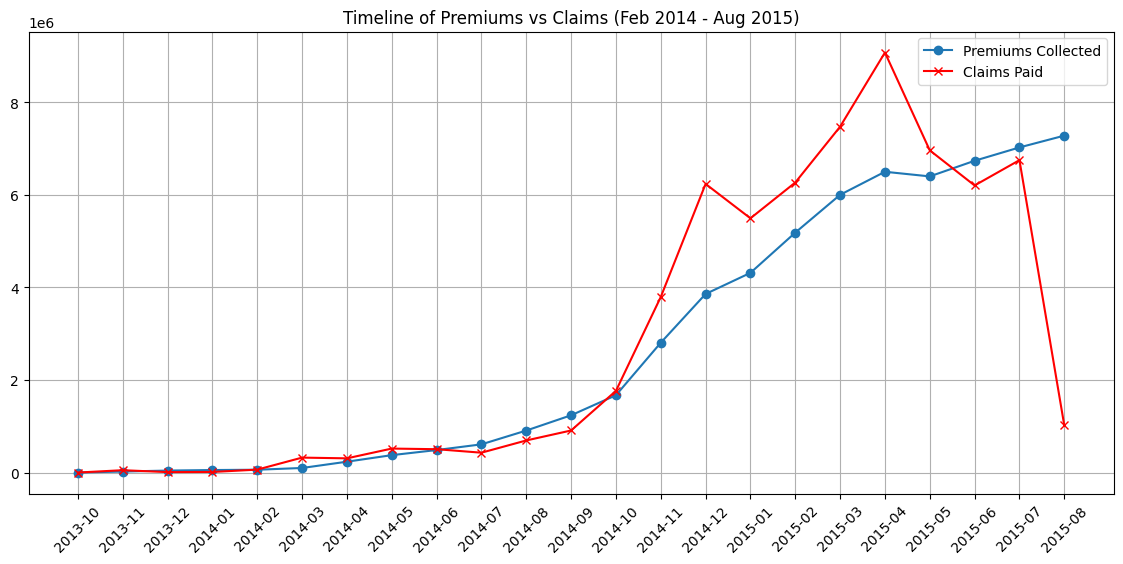

In [11]:
# Aggregate by Month
monthly_trends = df.groupby(df['TransactionMonth'].dt.to_period('M')).agg({
    'TotalPremium': 'sum',
    'TotalClaims': 'sum'
}).reset_index()

monthly_trends['TransactionMonth'] = monthly_trends['TransactionMonth'].astype(str)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(monthly_trends['TransactionMonth'], monthly_trends['TotalPremium'], label='Premiums Collected', marker='o')
plt.plot(monthly_trends['TransactionMonth'], monthly_trends['TotalClaims'], label='Claims Paid', marker='x', color='red')
plt.xticks(rotation=45)
plt.title('Timeline of Premiums vs Claims (Feb 2014 - Aug 2015)')
plt.legend()
plt.grid(True)
plt.show()

## Creative Visualizations

### The Profitability Matrix (Heatmap)

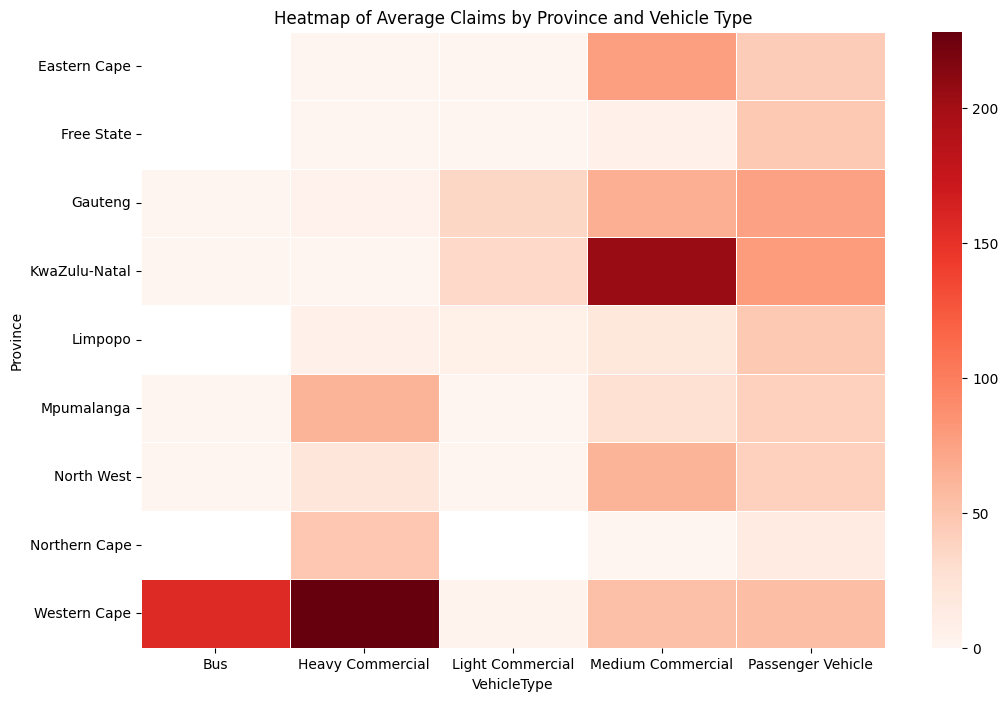

In [12]:
# Group by Vehicle Type and Province to find high-risk segments
pivot_table = df.pivot_table(index='Province', columns='VehicleType', values='TotalClaims', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='Reds', linecolor='white', linewidths=0.5)
plt.title('Heatmap of Average Claims by Province and Vehicle Type')
plt.show()

### Gender vs Risk (Violin Plot)

/tmp/ipykernel_31707/217528000.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Gender', y='TotalClaims', data=subset, inner='quartile', palette='muted')


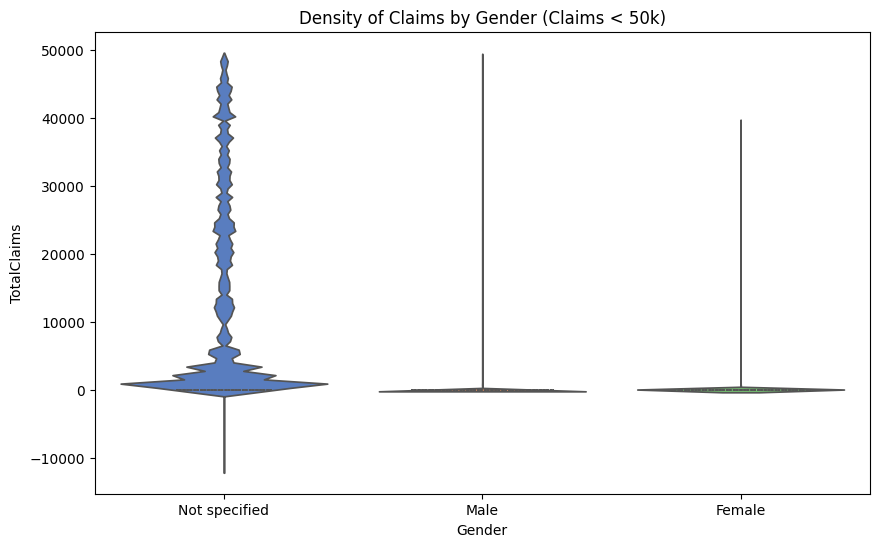

In [13]:
# Check if Gender affects claims
plt.figure(figsize=(10, 6))
# Filter out extreme outliers for better visualization
subset = df[df['TotalClaims'] < 50000] 
sns.violinplot(x='Gender', y='TotalClaims', data=subset, inner='quartile', palette='muted')
plt.title('Density of Claims by Gender (Claims < 50k)')
plt.show()

### Premium Optimization Scatter

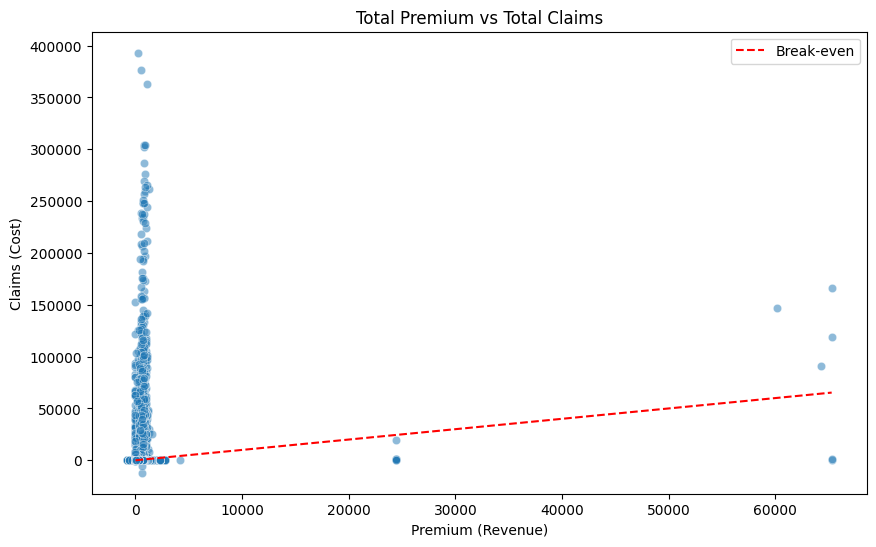

In [14]:
analyzer.plot_premium_vs_claims()

### Data Summarization & Descriptive Statistics

In [15]:
# 1. Generate the detailed stats table
stats_df = analyzer.get_comprehensive_stats(columns=['TotalPremium', 'TotalClaims', 'CalculatedPremiumPerTerm'])

# 2. Display formatted table
print("--- Key Financial Descriptive Statistics ---")
display(stats_df.round(2))

# 3. Interpretation Logic (Automated Insights)
premium_skew = stats_df.loc['Skewness', 'TotalPremium']
claims_cv = stats_df.loc['CV (Variability)', 'TotalClaims']

print("\n--- Interpretation ---")
if premium_skew > 1:
    print(f"-> TotalPremium is highly right-skewed ({premium_skew:.2f}). Most clients pay low premiums, with a few paying very high amounts.")

print(f"-> Coefficient of Variation (CV) for Claims is {claims_cv:.2f}. " 
      "A CV > 1 indicates high volatility, meaning risk is not evenly spread.")

--- Key Financial Descriptive Statistics ---


,TotalPremium,TotalClaims,CalculatedPremiumPerTerm
Count,1000098.00,1000098.00,1000098.00
Mean,61.91,64.86,117.88
Median,2.18,0.00,8.44
Standard Deviation,230.28,2384.07,399.70
Variance,53030.96,5683812.15,159761.47
Min,-782.58,-12002.41,0.00
Max,65282.60,393092.11,74422.17
Range,66065.18,405094.52,74422.17
Skewness,138.60,69.93,122.97
Kurtosis,37176.19,6791.93,22210.70



--- Interpretation ---
-> TotalPremium is highly right-skewed (138.60). Most clients pay low premiums, with a few paying very high amounts.
-> Coefficient of Variation (CV) for Claims is 36.76. A CV > 1 indicates high volatility, meaning risk is not evenly spread.
